# Identify money laundering with anomaly detection

This notebook demonstrates how DataRobot performs outlier detection with a use case that prevents money laundering: the process of hiding illicitly obtained money. The notebook uses a historical money transactions dataset and trains anomaly detection models to detect outliers. 

In the sample dataset, fraudulent transactions are identified in the `SAR` column; however, in this use case, that information will not be used to train the model. This is because, in most cases, money laundering goes undetected and [anomaly detection in DataRobot](https://docs.datarobot.com/en/docs/modeling/special-workflows/unsupervised/anomaly-detection.html) can help identify when it occurs. This notebook uses a small subset of the data to evaluate how well the unsupervised approach works, as you can compare the results to the data that's already labeled as fraud (the `SAR` column).

## Requirements

- Python version 3.7.3
- DataRobot API version 2.19.0

Note that small adjustments may be required depending on the Python and DataRobot API versions you are using.

Full documentation of the Python package can be found [here](https://datarobot-public-api-client.readthedocs-hosted.com).

## Import libraries

In [ ]:
import datarobot as dr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

%matplotlib inline
import time

import seaborn as sns
from sklearn.metrics import f1_score

## Upload data

In the sample dataset, [available for download](aml.csv), `SAR` is the target feature. For the purposes of this notebook, the target is not used for training, but instead to evaluate the accuracy of the anomaly detection models built in later steps. This is because you do not want to cause [target leakage](https://docs.datarobot.com/en/docs/glossary/index.html#target-leakage).

In [2]:
data_path = "https://docs.datarobot.com/en/docs/api/guide/common-case/aml.csv"

df = pd.read_csv(data_path)  # Add your dataset here
df.head()

ALERT  SAR  kycRiskScore    income  tenureMonths  creditScore state  \
0      1    0             3  110300.0             5          757    PA   
1      1    0             2  107800.0             6          715    NY   
2      1    0             1   74000.0            13          751    MA   
3      1    0             0   57700.0             1          659    NJ   
4      1    0             1   59800.0             3          709    PA   

   nbrPurchases90d  avgTxnSize90d  totalSpend90d  ... indCustReqRefund90d  \
0               10         153.80        1538.00  ...                   1   
1               22           1.59          34.98  ...                   1   
2                7          57.64         403.48  ...                   1   
3               14          29.52         413.28  ...                   1   
4               54         115.77        6251.58  ...                   1   

   totalRefundsToCust90d  nbrPaymentsCashLike90d  maxRevolveLine  indOwnsHome  \
0                  45.82                       5            6000            0   
1                  67.40                       0           10000            1   
2                 450.69                       0           10000            0   
3                  71.43                       0            8000            1   
4                2731.39                       3            7000            1   

   nbrInquiries1y  nbrCollections3y  nbrWebLogins90d  nbrPointRed90d  PEP  
0               3                 0                6               1    0  
1               3                 0               87               0    0  
2               3                 0                6               0    0  
3               5                 0                7               2    0  
4               1                 0                8               1    0  

[5 rows x 31 columns]

## Connect to DataRobot

To use this notebook, you first need to establish a connection between your machine and the DataRobot instance. Read more about different options for [connecting to DataRobot](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [ ]:
# If the config file is not in the default location described in the API Quickstart guide, '~/.config/datarobot/drconfig.yaml', then you will need to call
# dr.Client(config_path='path-to-drconfig.yaml')

## Clean and split the data

Use the snippets below to split the data into a training set and an external test set. The second line removes the target from the training dataset.

In [14]:
train, external_test = train_test_split(df, test_size=0.15)

train = train.drop("SAR", axis=1)

## Create a project

Once connected to DataRobot, you can create a project using the `dr.Project.create` and `dr.Project.set_target()` methods. Include `unsupervised_mode = True` to enable Autopilot without a target feature.

In [ ]:
project = dr.Project.create(project_name="Outlier Detection", sourcedata=train)

project.set_target(unsupervised_mode=True, worker_count=-1)
project.wait_for_autopilot()

## Unlock holdout

DataRobot uses [Synthetic AUC](https://docs.datarobot.com/en/docs/modeling/special-workflows/unsupervised/anomaly-detection.html#synthetic-auc-metric) to evaluate model performance. Synthetic AUC is a useful metric to see if a model can detect anomalies, but it is not an actual representation of accuracy. Use the snippet below to train all models to 100% and evaluate them all against the labeled test data. The top-performing model will be bound to `best_model`.

In [144]:
project.unlock_holdout()

for model in project.get_models():
    model.train(100)

# Sleep while waiting for the modeling jobs to complete
while len(project.get_model_jobs()) != 0:
    time.sleep(5)

# Overwrite best_model with the newly trained top-performing model
models = []
for model in project.get_models():
    if model.sample_pct == 100:
        models.append(model)

## Upload the test dataset

When working with anomaly detection, note that for training data, the most anomalous value will have a score of 1. When you score data, if an observation is even more anomalous than the training data's values, it will have a score greater than 1.

Anomalous values are *normalized*, which requires applying business logic to get an accurate result. Experts suggest that you can expect 10% of transactions to be fraudulent; therefore, you can assume that 10% of the most anomalous values represent fraud.

In [ ]:
# Upload external test data for predictions
dataset_from_path = project.upload_dataset(external_test)

## Make predictions

Use the function below to test predictions with the external test dataset. This function includes a prediction threshold based on quantile.

In [146]:
def get_predictions(model, q=95):
    predict_job = model.request_predictions(dataset_from_path.id)
    predictions = predict_job.get_result_when_complete()
    p = predictions.join(external_test.reset_index())[["prediction", "SAR"]]
    p_threshold = np.quantile(p["prediction"], 0.95)

    p["prediction_binary"] = p["prediction"].apply(lambda x: 1 if x >= p_threshold else 0)

    return p

## Plot a confusion matrix for each model

The function below plots a [confusion matrix](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/roc-curve-tab/confusion-matrix.html) for each model based on the prediction threshold. You can experiment with both accuracy metrics and prediction thresholds and analyze the new results.

F1 Score:  0.53007208859048 Model('Mahalanobis Distance Ranked Anomaly Detection with PCA and Calibration')
F1 Score:  0.5251254789966957 Model('Mahalanobis Distance Ranked Anomaly Detection with PCA and Calibration')
F1 Score:  0.6240576708723841 Model('Isolation Forest Anomaly Detection with Calibration')
F1 Score:  0.6685771572164438 Model('Isolation Forest Anomaly Detection with Calibration')
F1 Score:  0.6240576708723841 Model('Anomaly Detection Blender')
F1 Score:  0.6290042804661685 Model('Anomaly Detection Blender')
F1 Score:  0.6388974996537373 Model('Anomaly Detection with Supervised Learning (XGB) and Calibration')
F1 Score:  0.5993246229034619 Model('Anomaly Detection with Supervised Learning (XGB) and Calibration')
F1 Score:  0.6537373284350906 Model('Anomaly Detection with Supervised Learning (XGB) and Calibration')
F1 Score:  0.6042712324972463 Model('Anomaly Detection with Supervised Learning (XGB) and Calibration')
F1 Score:  0.09937560287698714 Model('One-Class SVM An

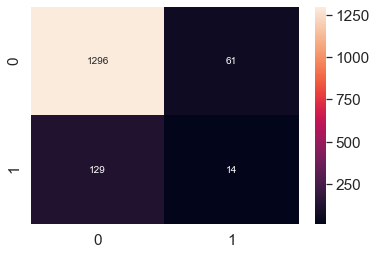

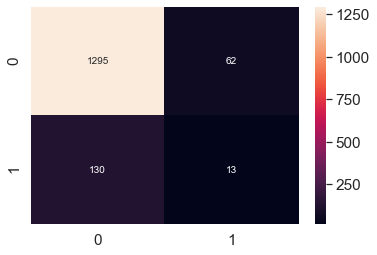

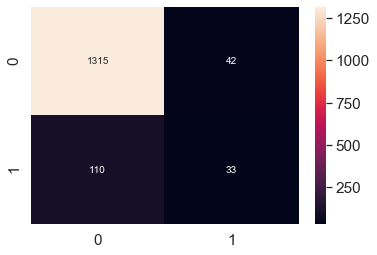

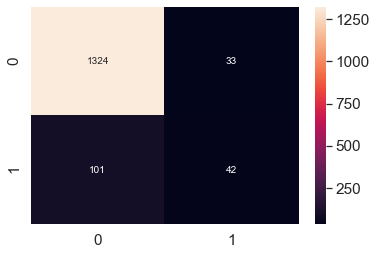

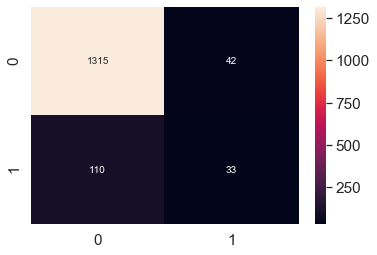

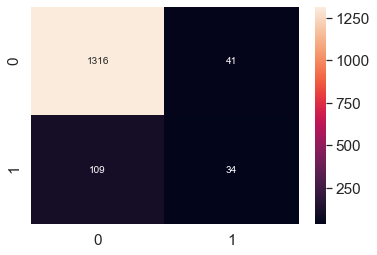

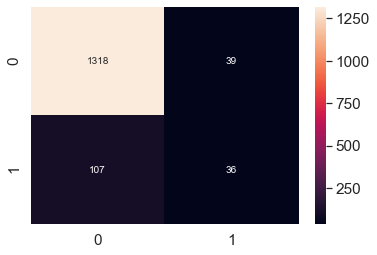

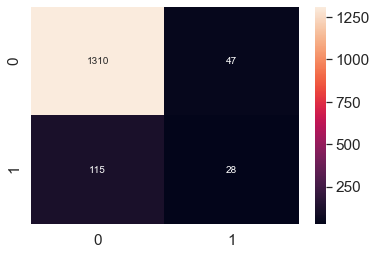

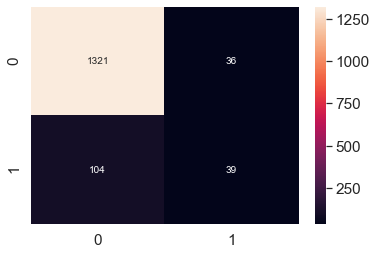

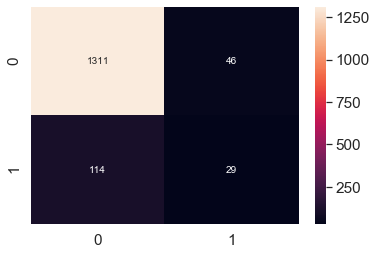

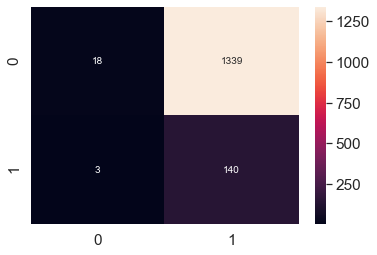

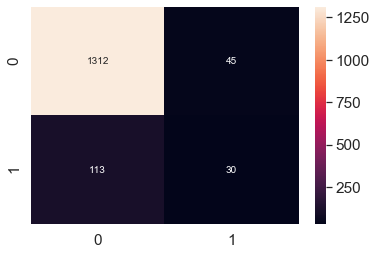

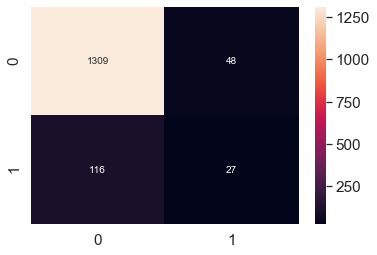

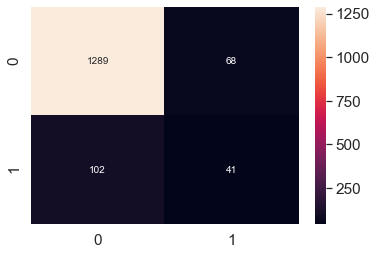

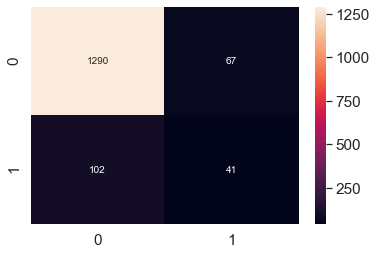

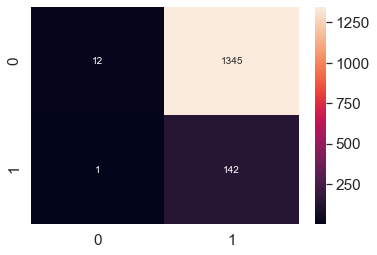

In [153]:
for i, model in enumerate(project.get_models()):
    plt.figure(i)
    result = get_predictions(model)
    cm = confusion_matrix(result["SAR"], result["prediction_binary"])
    df_cm = pd.DataFrame(cm, range(2), range(2))
    print(
        "F1 Score: ", f1_score(result["SAR"], result["prediction_binary"], average="macro"), model
    )
    sns.heatmap(df_cm, annot=True, fmt="g")